In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential
from keras.metrics import mean_absolute_error, mae, mse
from keras.layers import Dense, Dropout, Input
from keras.regularizers import l2, l1_l2

from datetime import datetime

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def load_data(url, columns=[1, 2, 4, 6, 11]):
  """ Load the dataset, change the column names, 
      and replace the categorical data by numeric values
  """
  # load data
  df = pd.read_csv(url, header=None, usecols=columns)
  print('Original Data shape: ', np.shape(df))

  # re-name all columns
  column_names = ['Price', 'PurchaseDate', 'PropertyType', 'LeaseDuration', 'City']
  df.columns = column_names
  
  # resplace column values
  df['PropertyType'] = df['PropertyType'].replace({'F':0, 'D':1, 'S':2, 'T':3, 'O':4})
  df['LeaseDuration'] = df['LeaseDuration'].replace({'L':0, 'F':1, 'U':2})
  df.loc[df['City']=='LONDON', 'City'] = 0
  df.loc[df['City'] != 0, 'City'] = 1

  # convert column values to appropriate dtype (to save memory)
  df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])
  df['Price'] = pd.to_numeric(df["Price"], downcast="integer")
  df['PropertyType'] = pd.to_numeric(df['PropertyType'], downcast='integer')
  df['LeaseDuration'] = pd.to_numeric(df["LeaseDuration"], downcast="integer")
  df['City'] = pd.to_numeric(df["City"], downcast="integer")
  return df

In [0]:
def split_train_test(df):
  """ Split the data into training and test dataset 
  """
  # purchases prior to 1/1/2016 as training 
  cutoff = datetime(2016, 1, 1)
  column_sels = ['Price', 'PropertyType', 'LeaseDuration', 'City']
  train_df = df.loc[df['PurchaseDate'] <= cutoff][column_sels]
  test_df = df.loc[df['PurchaseDate'] > cutoff][column_sels] 
  
  # remove duplicates
  train_df.drop_duplicates(keep='first', inplace=True)
  test_df.drop_duplicates(keep='first', inplace=True)
  print("Train (and val) shape: ", train_df.shape)
  print("Test shape: ", test_df.shape)  
  return train_df, test_df  

In [0]:
def split_train_val(train_df, perc=0.2):
  """ Split training into train and validation (perc %) dataset
  """ 
  train_df, val_df = train_test_split(train_df, test_size=perc, random_state=2019)
  print("Partial Train shape : ", train_df.shape)
  print("Val shape : ", val_df.shape)  
  return train_df, val_df  

In [0]:
def prep(train_df, val_df, test_df):
  """ Prepare inputs/targets pair for training, val, and testing
      using one-hot encoding (for categorical data), and 
      down-scale the target values (prices) 
  """
  # training 
  train_X = train_df[['PropertyType', 'LeaseDuration', 'City']]
  train_y = train_df['Price']

  # validation
  val_X = val_df[['PropertyType', 'LeaseDuration', 'City']]
  val_y = val_df['Price']

  # testing 
  test_X = test_df[['PropertyType', 'LeaseDuration', 'City']]
  test_y = test_df['Price']

  # one-hot encoding the inputs
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(train_X)
  train_X = ohc.transform(train_X)
  val_X = ohc.transform(val_X)
  test_X = ohc.transform(test_X)

  # convert the targets to smaller range
  train_y = np.log1p(train_y * 1e-3)
  val_y = np.log1p(val_y * 1e-3)
  test_y = np.log1p(test_y * 1e-3)
  return (train_X, train_y), (val_X, val_y), (test_X, test_y)  

In [0]:
def build_model(input_size):
  """ Build and compile a fully-connected neural network 
  """
  inp = Input(shape=(input_size,))
  fc1 = Dense(100, activation='relu', kernel_regularizer=l2(0.001))(inp)
  do1 = Dropout(0.5)(fc1)
  fc2 = Dense(200, activation='relu', kernel_regularizer=l2(0.001))(do1)
  do2 = Dropout(0.5)(fc2)
  fc3 = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(do2)
  do3 = Dropout(0.5)(fc3)
  fc4 = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(do3)
  out = Dense(1)(fc4)
  model = Model(inputs=inp, outputs=out)
  print(model.summary())
  model.compile(optimizer=RMSprop(lr=1e-3), loss=mse, metrics=[mae])  
  return model

In [0]:
def train_model(model, epochs=10, batch_size=10000):
  """ Train a compiled model
  """
  history = model.fit(train_X, train_y, batch_size=batch_size, verbose=1,
                      epochs=epochs, validation_data=(val_X, val_y))  
  train_mae = history.history['mean_absolute_error']
  val_mae = history.history['val_mean_absolute_error']  
  return train_mae, val_mae

In [0]:
def train_model_with_cv(train_df, val_df, epochs=500, batch_size=512, kfold=10):
  """ Train with k-fold cross-validation
  """
  num_samples = np.shape(train_df)[0] // kfold
  train_errs = []
  val_errs = []

  for i in range(kfold):
    print('Processing fold {0}'.format(i))

    # prepare train and val data
    val_data = train_df.iloc[i*num_samples:(i+1)*num_samples]
    train_data = pd.concat([train_df.iloc[:i*num_samples], train_df.iloc[(i+1)*num_samples:]])
    (train_X, train_y), (val_X, val_y), (test_X, test_y) = prep(train_data, val_data, test_df)

    # build a new model
    model = build_model(np.shape(train_X)[1])
    train_mae, val_mae = train_model(model, epochs, batch_size)

    # append train/val errs to error lists
    train_errs.append(train_mae)
    val_errs.append(val_mae)

  return train_errs, val_errs

In [0]:
def plot_train_val_error(train_errs, val_errs):
  """ Plot the train/val loss over epochs
  """
  epochs = len(train_errs)
  plt.plot(range(1, epochs+1), train_errs, label='Training Loss')
  plt.plot(range(1, epochs+1), val_errs, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [0]:
# smooth the val curve in the above plot
def smooth_curve(points, factor=0.9):
  """ Smooth with an exponential moving average
  """
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [11]:
# load the data
url = '/content/drive/My Drive/pp-complete.csv'
df = load_data(url)
train_df, test_df = split_train_test(df)

Original Data shape:  (24852949, 5)
Train (and val) shape:  (317952, 4)
Test shape:  (144006, 4)


In [12]:
train_df, val_df = split_train_val(train_df)
(train_X, train_y), (val_X, val_y), (test_X, test_y)  = prep(train_df, val_df, test_df)

Partial Train shape :  (254361, 4)
Val shape :  (63591, 4)


In [14]:
# fitting the model using cross validation with k folds
train_errs, val_errs = train_model_with_cv(train_df, val_df, epochs=50)

Processing fold 0
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1100      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100) 

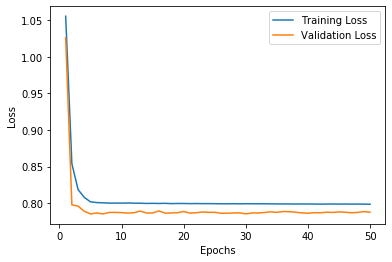

In [18]:
# plot the average train/val loss
avg_train = [np.mean(i) for i in zip(*train_errs)]
avg_val = [np.mean(i) for i in zip(*val_errs)]
plot_train_val_error(avg_train, avg_val)

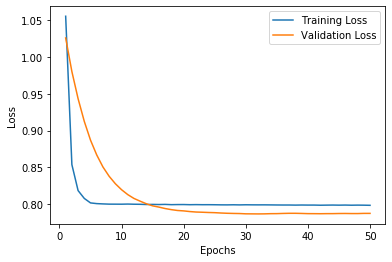

In [20]:
# plot the train and val loss (smoother curve)
smooth_avg_val = smooth_curve(avg_val, factor=0.8)
plot_train_val_error(avg_train, smooth_avg_val)